# Create Data Set

In [91]:
%matplotlib inline
import matplotlib.pyplot as plt
import imageio
import numpy as np
import random
import os
from scipy.ndimage import zoom

## zoom manipulation

In [92]:
def clipped_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]
    
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    if zoom_factor < 1:

        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)

    elif zoom_factor > 1:

        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)

        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]
        
    else:
        out = img
    return out

## save reverse img

In [93]:
def save_reverse_pic(img, f_data, f_labels, is_TF):
    if img is not None and img.shape == (81,81,3):
        rev=img[:,::-1,:]
        tag = b'1' if is_TF else b'0'
        np.ndarray.tofile(rev,f_data)
        f_labels.write(tag)

## save zoom img

In [94]:
def save_zoom_pic(img, f_data, f_labels, is_TF):
    if img is not None and img.shape == (81,81,3): 
        img = clipped_zoom(img, 1.5)
        tag = b'1' if is_TF else b'0'
        np.ndarray.tofile(img,f_data)
        f_labels.write(tag)

## save img

In [95]:
def save_pic(img, f_data, f_labels, is_TF):
    if img is not None and img.shape == (81,81,3): 
        tag = b'1' if is_TF else b'0'
        np.ndarray.tofile(img,f_data)
        f_labels.write(tag)

# Crop images - 81x81x3

In [96]:
def crop_pic(mat, x, y):
    if x-40 < 0 or y-40 < 0 or x+40  > mat.shape[1] or y+40 > mat.shape[0]:
        return None
    c = mat[x-40:x+41, y-40:y+41, 0:3]
    
    return c

In [106]:
def cropped_traffic_lights(original_img, label_img, data, labels):    
    mask = ((label_img[:,:,0]==250) & (label_img[:,:,1]==170)  & (label_img[:,:,2]==30))
    
    Ti, Tj = np.where(mask == True)
    if len(Ti) == 0:
        return
    Fi, Fj = np.where(mask == False)
    size = 40
    for i in range(5):
        rT=random.randint(0,len(Ti)-1)
        rF=random.randint(0,len(Fi)-1)

        Tx ,Ty = Ti[rT],Tj[rT]
        Fx, Fy = Fi[rF],Fj[rF]
        
        tl_cropped = crop_pic(original_img, Tx, Ty)
        ntl_cropped = crop_pic(original_img, Fx, Fy)
        
        save_zoom_pic(tl_cropped, data, labels, 1)
        save_zoom_pic(ntl_cropped, data, labels, 0)

## Laod TRAIN Directories images, crop and save to binary file

In [107]:
label_dir = r'C:\Users\USER\BootCamp\Python\Mobileye Project\CityScapes\gtFine\val'
img_dir = r'C:\Users\USER\BootCamp\Python\Mobileye Project\CityScapes\leftImg8bit\val'

In [108]:
images = []
for r, d, f in os.walk(img_dir):
    for img in f:
        if '.png' in img:
            images.append(os.path.join(r, img))         

In [109]:
with open('data.bin', 'ab') as data:
    with open('labels.bin', 'ab') as labels:
        for i in range(len(images)):
            color_path = images[i].replace(img_dir,"").replace("_leftImg8bit.png","_gtFine_color.png")
            label_img = imageio.imread(label_dir + color_path)
            original_img = imageio.imread(images[i])
            cropped_traffic_lights(original_img, label_img, data, labels)
            if i % 100 == 0:
                print(f"logging... {i} / {len(images)}")
        print("end")

logging... 0 / 500
logging... 100 / 500
logging... 200 / 500
logging... 300 / 500
logging... 400 / 500
end


## Length of DS

In [110]:
num_ds = np.fromfile(r"C:\Users\USER\BootCamp\Python\Mobileye Project\CityScapes\data.bin", dtype="uint8").shape[0]//(81*81*3)
num_ds

3803

## Display a sample of DS

In [38]:
def show_sample(f_data, f_label, idx, crop_size):
    num_img = np.fromfile(f_data, dtype="uint8").shape[0] // (crop_size*crop_size*3) 
    fp = np.memmap(f_data, mode='r+', shape=(num_img, crop_size, crop_size, 3))
    with open( r"C:\Users\USER\BootCamp\Python\Mobileye Project\CityScapes\labels.bin", 'r') as labels:
        tag = labels.read()[idx]
    return fp[idx] , tag

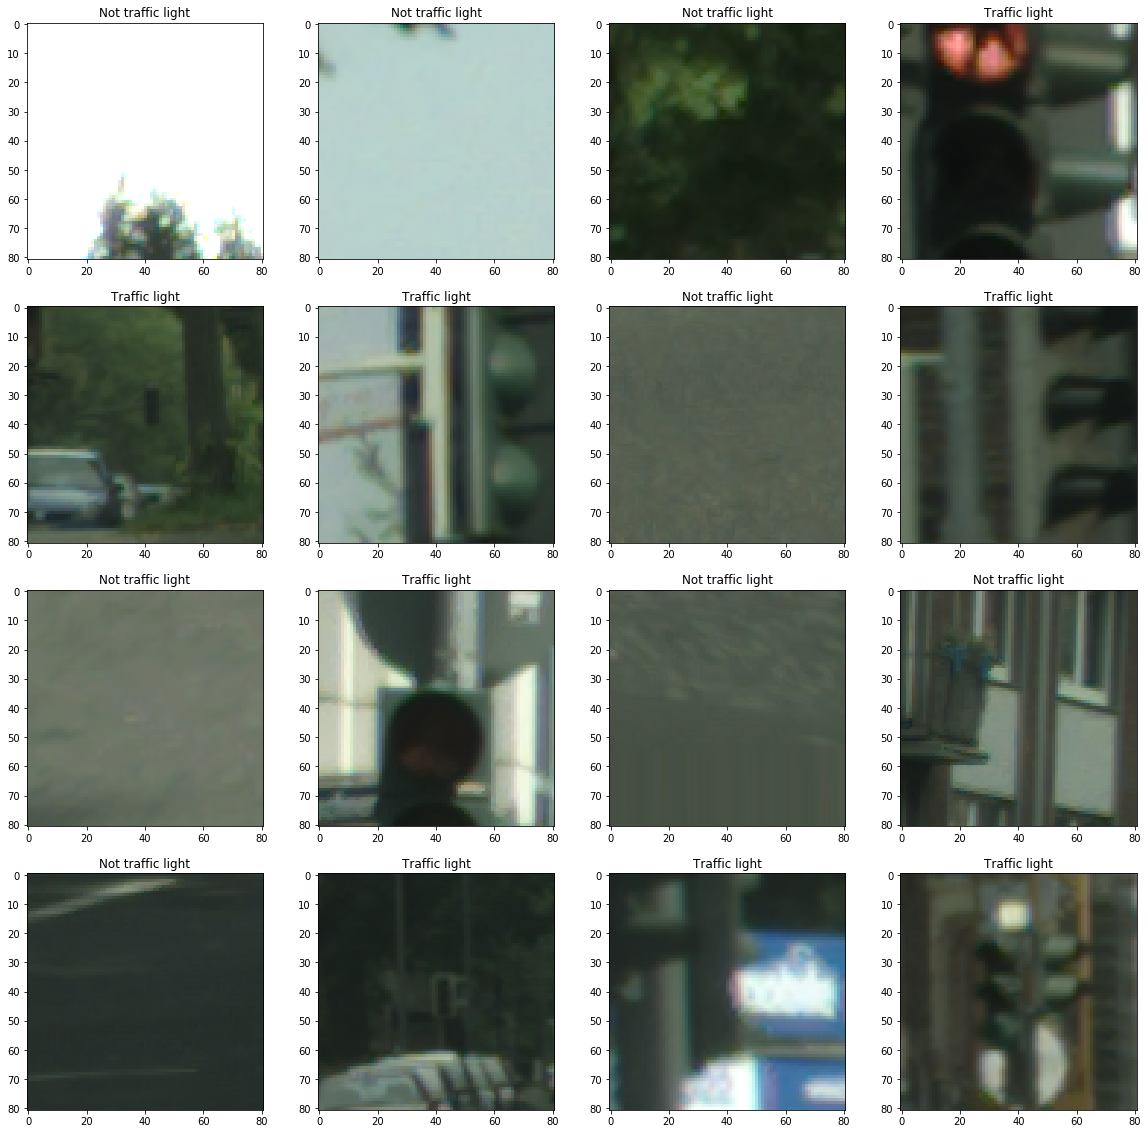

In [111]:
fig, axs = plt.subplots(4, 4, figsize=(20,20))
   
for i in range(4):
    for j in range(4):
        idx = random.randint(0,nnn-1)
        img, tag = show_sample(r"C:\Users\USER\BootCamp\Python\Mobileye Project\CityScapes\data.bin", r"C:\Users\USER\BootCamp\Python\Mobileye Project\CityScapes\labels.bin", idx, 81)
        axs[i, j].imshow(img)
        if tag == "1":
            axs[i, j].set_title('Traffic light')
        else:
            axs[i, j].set_title('Not traffic light')